In [1]:
%pip install opencv-python Pillow numpy tensorflow


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [15]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, map_coordinates



In [16]:
# Function for rotation
def rotate_image(image, angle_range=(-30, 30)):
    angle = random.uniform(angle_range[0], angle_range[1])
    rows, cols, _ = image.shape
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (cols, rows))
    return rotated_image

# Function for translation
def translate_image(image, tx_range=(-30, 30), ty_range=(-30, 30)):
    tx = random.uniform(tx_range[0], tx_range[1])
    ty = random.uniform(ty_range[0], ty_range[1])
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    rows, cols, _ = image.shape
    translated_image = cv2.warpAffine(image, translation_matrix, (cols, rows))
    return translated_image

# Function for scaling
def scale_image(image, scale_range=(0.8, 1.2)):
    scale = random.uniform(scale_range[0], scale_range[1])
    rows, cols, _ = image.shape
    scaled_image = cv2.resize(image, None, fx=scale, fy=scale)
    return scaled_image

# Function for shearing
def shear_image(image, shear_range=(-0.2, 0.2)):
    shear = random.uniform(shear_range[0], shear_range[1])
    rows, cols, _ = image.shape
    M = np.float32([[1, shear, 0], [shear, 1, 0]])
    sheared_image = cv2.warpAffine(image, M, (cols, rows))
    return sheared_image

# Function for horizontal flipping
def flip_image(image):
    return cv2.flip(image, 1)

# Function for cropping
def crop_image(image, crop_fraction=0.1):
    h, w, _ = image.shape
    crop_h = int(h * crop_fraction)
    crop_w = int(w * crop_fraction)
    x1 = random.randint(0, crop_w)
    y1 = random.randint(0, crop_h)
    x2 = w - random.randint(0, crop_w)
    y2 = h - random.randint(0, crop_h)
    cropped_image = image[y1:y2, x1:x2]
    return cropped_image


In [17]:
# Function for brightness adjustment
def adjust_brightness(image, factor_range=(0.5, 1.5)):
    factor = random.uniform(factor_range[0], factor_range[1])
    enhancer = ImageEnhance.Brightness(Image.fromarray(image))
    return np.array(enhancer.enhance(factor))

# Function for contrast adjustment
def adjust_contrast(image, factor_range=(0.5, 1.5)):
    factor = random.uniform(factor_range[0], factor_range[1])
    enhancer = ImageEnhance.Contrast(Image.fromarray(image))
    return np.array(enhancer.enhance(factor))

# Function for saturation adjustment
def adjust_saturation(image, factor_range=(0.5, 1.5)):
    factor = random.uniform(factor_range[0], factor_range[1])
    enhancer = ImageEnhance.Color(Image.fromarray(image))
    return np.array(enhancer.enhance(factor))

# Function for hue shifting
def adjust_hue(image, shift_range=(-10, 10)):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_image[..., 0] = np.clip(hsv_image[..., 0] + random.randint(shift_range[0], shift_range[1]), 0, 179)
    return cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)

# Function for gamma correction
def adjust_gamma(image, gamma_range=(0.5, 2.0)):
    gamma = random.uniform(gamma_range[0], gamma_range[1])
    lookup_table = np.array([((i / 255.0) ** gamma) * 255 for i in range(256)], dtype=np.uint8)
    return cv2.LUT(image, lookup_table)


In [18]:
# Function for adding Gaussian noise
def add_gaussian_noise(image, mean=0, var=0.1):
    sigma = var ** 0.5
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = np.clip(image + noise, 0, 255)
    return noisy_image.astype(np.uint8)

# Function for adding salt-and-pepper noise
def add_salt_pepper_noise(image, amount=0.01):
    noisy_image = image.copy()
    total_pixels = image.size
    num_salt = int(total_pixels * amount)
    num_pepper = int(total_pixels * amount)
    # Salt noise (white pixels)
    for _ in range(num_salt):
        x, y = random.randint(0, image.shape[0] - 1), random.randint(0, image.shape[1] - 1)
        noisy_image[x, y] = 255
    # Pepper noise (black pixels)
    for _ in range(num_pepper):
        x, y = random.randint(0, image.shape[0] - 1), random.randint(0, image.shape[1] - 1)
        noisy_image[x, y] = 0
    return noisy_image


In [24]:
def elastic_deform(image, alpha=34, sigma=4):
    """
    Elastic deformation for image augmentation.
    Args:
        image (ndarray): Input image.
        alpha (float): Scaling factor for deformation intensity.
        sigma (float): Standard deviation for Gaussian filter (controls smoothness of deformation).
    
    Returns:
        ndarray: Elastic deformed image.
    """
    # Get the shape of the image
    shape = image.shape
    height, width = shape[:2]
    
    # Generate random displacement fields
    random_state = np.random.RandomState(None)
    dx = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode="constant", cval=0)
    dy = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode="constant", cval=0)
    
    # Scale the displacement fields
    dx *= alpha
    dy *= alpha
    
    # Create meshgrid for pixel coordinates
    x, y = np.meshgrid(np.arange(width), np.arange(height))
    
    # Apply the displacement to the meshgrid
    distorted_image = np.zeros_like(image)
    for i in range(3):  # For each color channel (R, G, B)
        distorted_image[:, :, i] = map_coordinates(image[:, :, i], [y + dy, x + dx], order=1, mode='reflect')
    
    return distorted_image

In [20]:
# Function for Gaussian blur
def apply_gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Function for Motion blur
def apply_motion_blur(image, kernel_size=5):
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
    kernel = kernel / kernel_size
    return cv2.filter2D(image, -1, kernel)


In [21]:
# Function for adding random occlusions
def add_occlusions(image, num_occlusions=1, size_range=(20, 60)):
    image_copy = image.copy()
    h, w, _ = image.shape
    for _ in range(num_occlusions):
        occlusion_size = random.randint(size_range[0], size_range[1])
        x1 = random.randint(0, w - occlusion_size)
        y1 = random.randint(0, h - occlusion_size)
        x2, y2 = x1 + occlusion_size, y1 + occlusion_size
        image_copy[y1:y2, x1:x2] = 0  # Black occlusion
    return image_copy


In [22]:
# Function to visualize the image
def visualize_augmented_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()


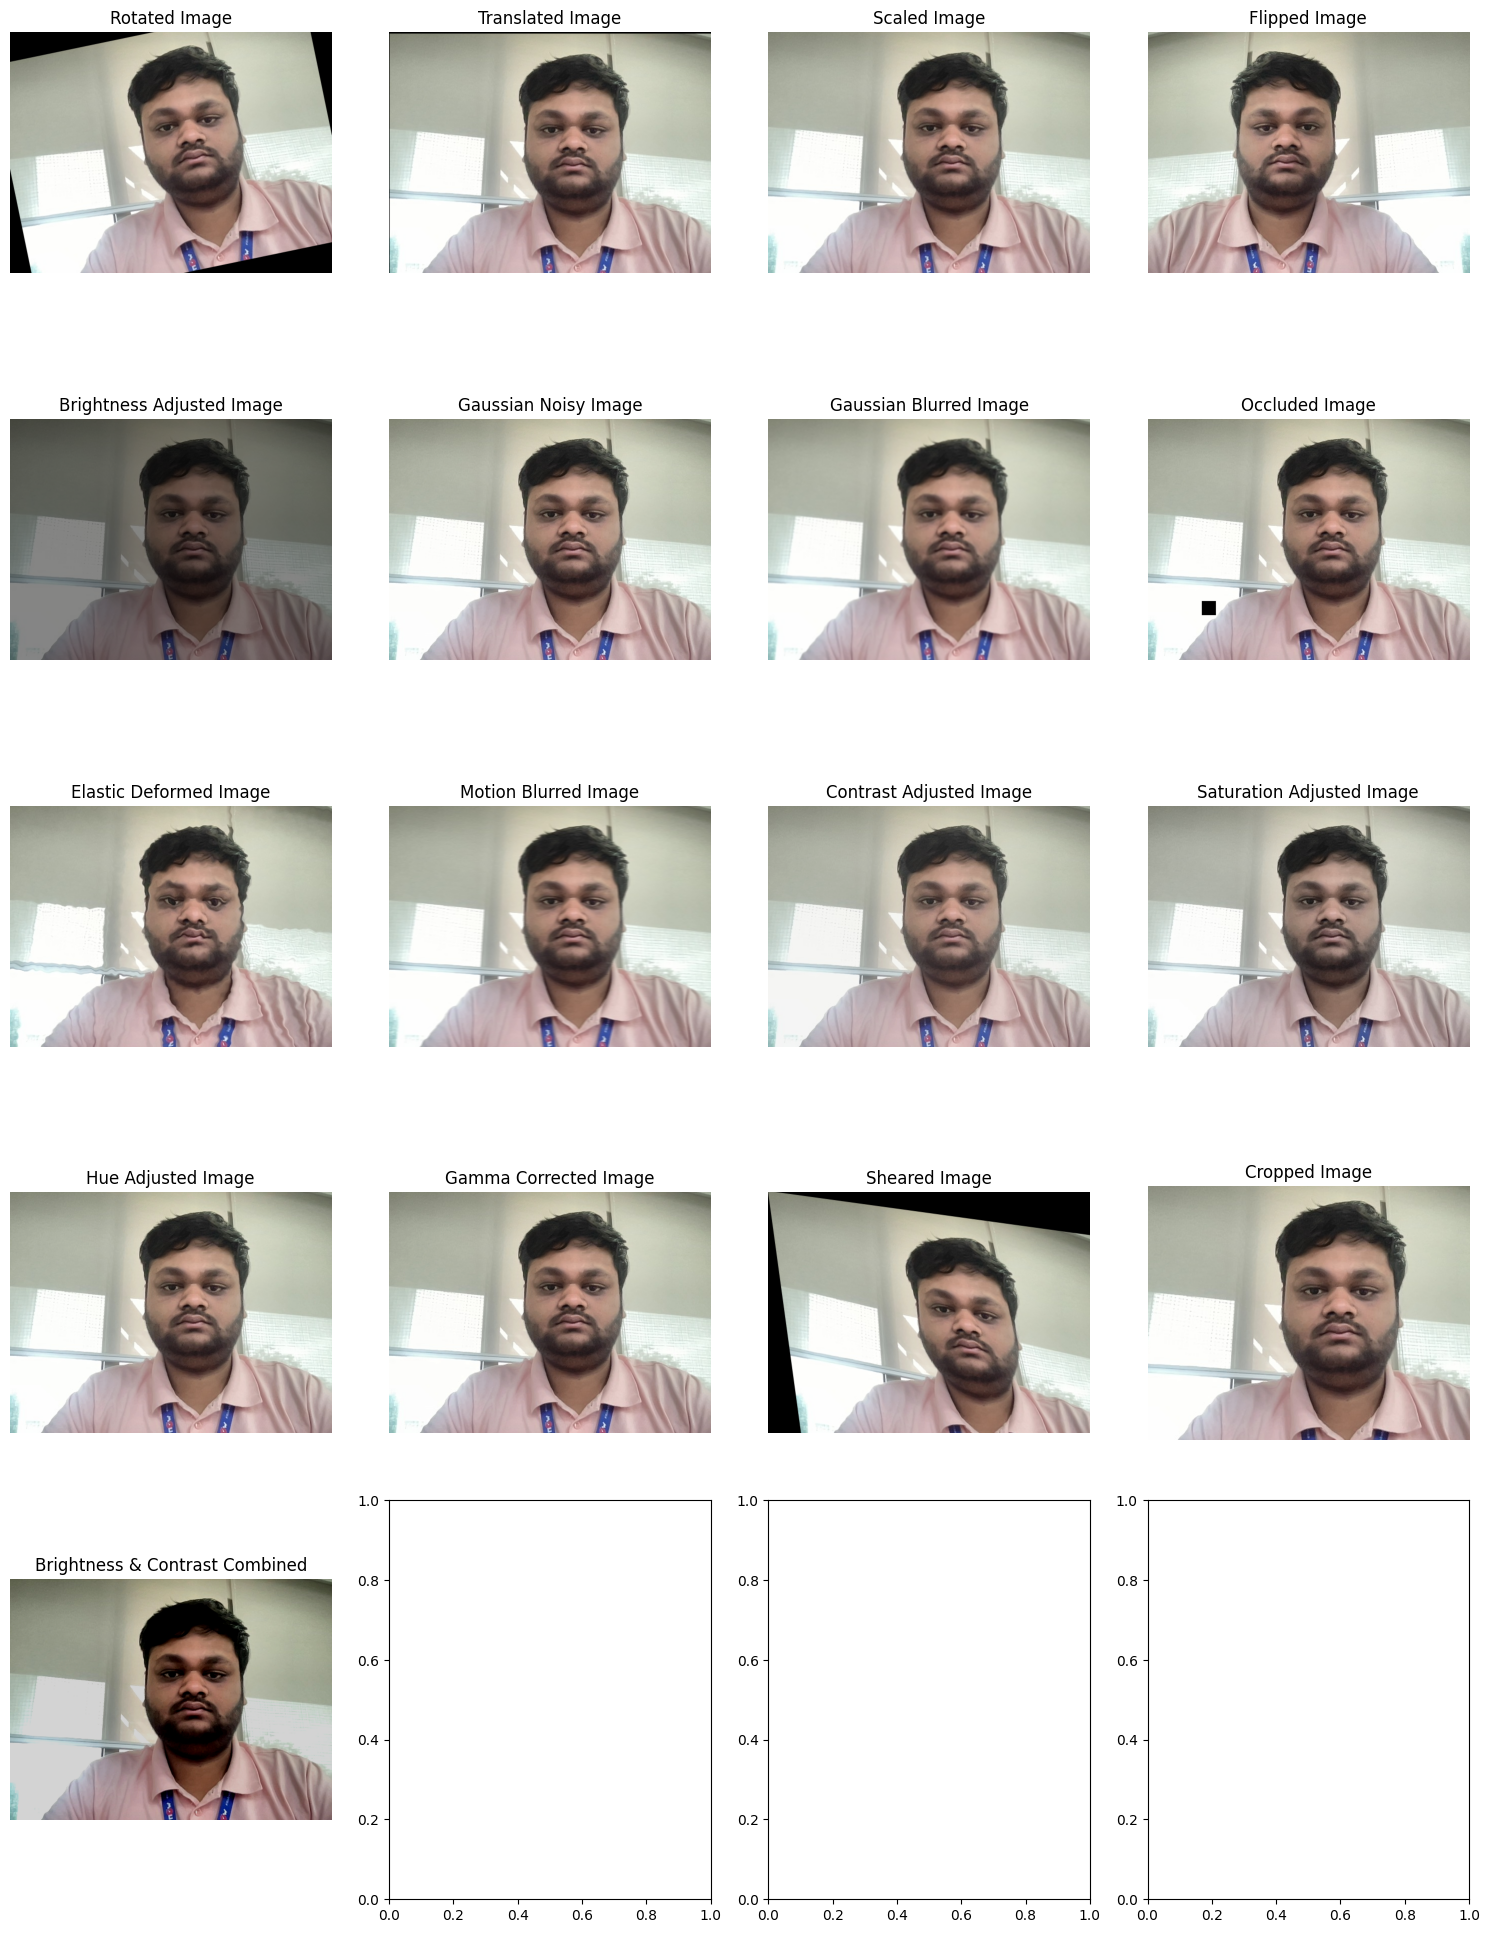

In [25]:
# Load a sample image
image_path = 'known_faces/Soubhik/Soubhik_0001.jpg'  # Replace with your image path
image = cv2.imread(image_path)

# Create a subplot to display each augmented image
fig, axes = plt.subplots(5, 4, figsize=(15, 20))  # 5 rows, 4 columns to accommodate all 17 augmentations
axes = axes.ravel()

# 1. Rotation
rotated_image = rotate_image(image)
axes[0].imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Rotated Image')
axes[0].axis('off')

# 2. Translation
translated_image = translate_image(image)
axes[1].imshow(cv2.cvtColor(translated_image, cv2.COLOR_BGR2RGB))
axes[1].set_title('Translated Image')
axes[1].axis('off')

# 3. Scaling
scaled_image = scale_image(image)
axes[2].imshow(cv2.cvtColor(scaled_image, cv2.COLOR_BGR2RGB))
axes[2].set_title('Scaled Image')
axes[2].axis('off')

# 4. Flipping
flipped_image = flip_image(image)
axes[3].imshow(cv2.cvtColor(flipped_image, cv2.COLOR_BGR2RGB))
axes[3].set_title('Flipped Image')
axes[3].axis('off')

# 5. Brightness Adjustment
brightness_image = adjust_brightness(image)
axes[4].imshow(cv2.cvtColor(brightness_image, cv2.COLOR_BGR2RGB))
axes[4].set_title('Brightness Adjusted Image')
axes[4].axis('off')

# 6. Gaussian Noise
noisy_image = add_gaussian_noise(image)
axes[5].imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
axes[5].set_title('Gaussian Noisy Image')
axes[5].axis('off')

# 7. Gaussian Blur
blurred_image = apply_gaussian_blur(image)
axes[6].imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
axes[6].set_title('Gaussian Blurred Image')
axes[6].axis('off')

# 8. Occlusion
occluded_image = add_occlusions(image)
axes[7].imshow(cv2.cvtColor(occluded_image, cv2.COLOR_BGR2RGB))
axes[7].set_title('Occluded Image')
axes[7].axis('off')

# 9. Elastic Deformation
elastic_image = elastic_deform(image)
axes[8].imshow(cv2.cvtColor(elastic_image, cv2.COLOR_BGR2RGB))
axes[8].set_title('Elastic Deformed Image')
axes[8].axis('off')

# 10. Motion Blur
motion_blurred_image = apply_motion_blur(image)
axes[9].imshow(cv2.cvtColor(motion_blurred_image, cv2.COLOR_BGR2RGB))
axes[9].set_title('Motion Blurred Image')
axes[9].axis('off')

# 11. Contrast Adjustment
contrast_image = adjust_contrast(image)
axes[10].imshow(cv2.cvtColor(contrast_image, cv2.COLOR_BGR2RGB))
axes[10].set_title('Contrast Adjusted Image')
axes[10].axis('off')

# 12. Saturation Adjustment
saturation_image = adjust_saturation(image)
axes[11].imshow(cv2.cvtColor(saturation_image, cv2.COLOR_BGR2RGB))
axes[11].set_title('Saturation Adjusted Image')
axes[11].axis('off')

# 13. Hue Shifting
hue_image = adjust_hue(image)
axes[12].imshow(cv2.cvtColor(hue_image, cv2.COLOR_BGR2RGB))
axes[12].set_title('Hue Adjusted Image')
axes[12].axis('off')

# 14. Gamma Correction
gamma_image = adjust_gamma(image)
axes[13].imshow(cv2.cvtColor(gamma_image, cv2.COLOR_BGR2RGB))
axes[13].set_title('Gamma Corrected Image')
axes[13].axis('off')

# 15. Shearing
sheared_image = shear_image(image)
axes[14].imshow(cv2.cvtColor(sheared_image, cv2.COLOR_BGR2RGB))
axes[14].set_title('Sheared Image')
axes[14].axis('off')

# 16. Cropping
cropped_image = crop_image(image)
axes[15].imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
axes[15].set_title('Cropped Image')
axes[15].axis('off')

# 17. Brightness and Contrast (combined for variety)
combined_image = adjust_brightness(adjust_contrast(image))
axes[16].imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
axes[16].set_title('Brightness & Contrast Combined')
axes[16].axis('off')

# Display the images
plt.tight_layout()
plt.show()

In [28]:
import os
from tqdm import tqdm


# Augmentation function list
augmentations = [
    rotate_image, translate_image, scale_image, flip_image, adjust_brightness,
    adjust_contrast, adjust_saturation, adjust_hue, adjust_gamma, add_gaussian_noise,
    apply_gaussian_blur, apply_motion_blur, shear_image, crop_image, add_occlusions,
    elastic_deform
]

# Apply augmentations to all images in the folder structure
def augment_images_in_folders(base_folder):
    for person_folder in tqdm(os.listdir(base_folder), desc="Processing persons"):
        person_path = os.path.join(base_folder, person_folder)
        if not os.path.isdir(person_path):
            continue
        
        # Get the highest existing number for image files
        image_files = sorted([f for f in os.listdir(person_path) if f.endswith('.jpg')])
        highest_num = int(image_files[-1].split('_')[-1].split('.')[0]) if image_files else 0
        
        # Process each image
        for image_file in tqdm(image_files, desc=f"Processing {person_folder}", leave=False):
            image_path = os.path.join(person_path, image_file)
            image = cv2.imread(image_path)
            
            # Apply each augmentation
            for aug in augmentations:
                augmented_image = aug(image)
                highest_num += 1
                new_filename = f"{person_folder}_{highest_num:04d}.jpg"
                cv2.imwrite(os.path.join(person_path, new_filename), augmented_image)

# Specify the base folder
base_folder = "../known_faces_augmented"
augment_images_in_folders(base_folder)

Processing persons: 100%|██████████| 5761/5761 [04:49<00:00, 19.92it/s]
